In [ ]:
!pip install pykan

# KAN

In [ ]:
# KAN
import time
import cv2
import numpy as np
import torch
import torchvision
from kan import KAN
import matplotlib.pyplot as plt

train_data = torchvision.datasets.MNIST(root="./mnist_data", train=True, download=True, transform=None)
test_data = torchvision.datasets.MNIST(root="./mnist_data", train=False, download=True, transform=None)


def preprocess_data(data):
    images = []
    labels = []
    for img, label in data:
        img = np.array(img)
        img = cv2.resize(img, (7, 7))
        img = img.flatten() / 255.0
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = preprocess_data(train_data)
test_images, test_labels = preprocess_data(test_data)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device")


dataset = {
    "train_input": torch.from_numpy(train_images).float().to(device),
    "train_label": torch.from_numpy(train_labels).long().to(device),
    "test_input": torch.from_numpy(test_images).float().to("cpu"),
    "test_label": torch.from_numpy(test_labels).long().to("cpu"),
}


def create_kan():
    return KAN(width=[7**2, 10, 10], grid=4, k=2)
model = create_kan()


def test_acc():
    with torch.no_grad():
        predictions = torch.argmax(model(dataset["test_input"]), dim=1)
        correct = (predictions == dataset["test_label"]).float()
        accuracy = correct.mean()
    return accuracy

def train_acc():
    with torch.no_grad():
        predictions = torch.argmax(model(dataset["train_input"].to('cpu')), dim=1)
        correct = (predictions == dataset["train_label"].to('cpu')).float()
        accuracy = correct.mean()
    return accuracy

start_time = time.time()

# Train the model
results = model.train(
    dataset,
    opt="LBFGS",
    steps=20,
    batch=512,
    loss_fn=torch.nn.CrossEntropyLoss(),
    metrics=(train_acc, test_acc),
)

end_time = time.time()
total_time = end_time - start_time
print(f"Training completed in: {total_time:.2f} seconds")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15891379.83it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 484006.50it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4416289.31it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3161388.78it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Using cpu device


train loss: 3.92e-01 | test loss: 9.00e-01 | reg: 2.17e+02 : 100%|██| 20/20 [15:17<00:00, 45.90s/it]


Test accuracy: 78.52%
total number of parameters: 11230


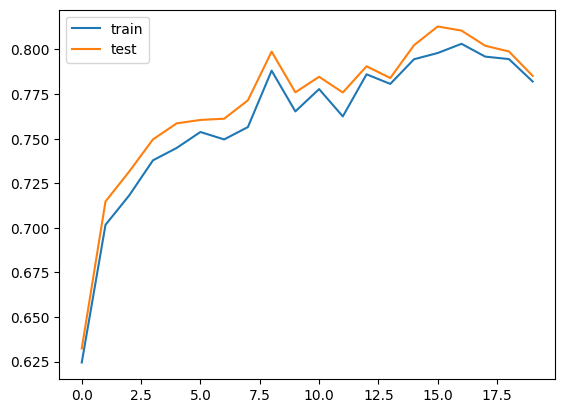

In [ ]:
acc = test_acc()
print(f"Test accuracy: {acc.item() * 100:.2f}%")
total_params = sum(p.numel() for p in model.parameters())
print(f"total number of parameters: {total_params}")

plt.plot(results["train_acc"], label="train")
plt.plot(results["test_acc"], label="test")
plt.legend()

# FourierKAN

In [2]:
# FourierKAN
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F

class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim

        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32))
        self.fouriercoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        nn.init.xavier_uniform_(self.fouriercoeffs)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))

    def forward(self, x):
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        outshape = x.shape[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))
        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

# CNNFourierKAN model definition
class CNNFourierKAN(nn.Module):
    def __init__(self):
        super(CNNFourierKAN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.fourierkan1 = NaiveFourierKANLayer(32*7*7, 128, initial_gridsize=4)
        self.fourierkan2 = NaiveFourierKANLayer(128, 10, initial_gridsize=4)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fourierkan1(x)
        x = self.fourierkan2(x)
        return x

# Dataset and DataLoader setup
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
# subset_indices = np.random.choice(len(train_dataset), int(len(train_dataset) * 0.1), replace=False)
# train_subset = Subset(train_dataset, subset_indices)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Model, Optimizer and Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNFourierKAN().to(device)
# optimizer = optim.LBFGS(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
optimizer = optim.RAdam(model.parameters(), lr=0.001)


# Training function
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for i, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data.to(device))
    loss = nn.CrossEntropyLoss()(output, target.to(device))
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
      print(f'Train Epoch: {epoch} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Evaluation function
def evaluate(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += nn.CrossEntropyLoss()(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Computing Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

start_time = time.time()

# Running training and evaluation
for epoch in range(0, 1):
  train(model, device, train_loader, optimizer, epoch)

end_time = time.time()
total_time = end_time - start_time
print(f"Training completed in: {total_time:.2f} seconds")
evaluate(model, device, test_loader)
total_params = count_parameters(model)
print(f'Total trainable parameters: {total_params}')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.354689
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.721679
Train Epoch: 0 [1280/60000 (2%)]	Loss: 1.137834
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.763371
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.541106
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.380498
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.324480
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.363739
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.238652
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.291255
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.341607
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.188485
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.379164
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.230453
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.204092
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.237257
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.299062
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.261384
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.291116
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.325736
Train Epoch: 0 [12800/60000 (

# 2DTaylorKAN+CNN

In [9]:
# 2DTaylorKAN + CNN
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class TaylorLayer(nn.Module):
  def __init__(self, input_dim, out_dim, order, addbias=True):
    super(TaylorLayer, self).__init__()
    self.input_dim = input_dim
    self.out_dim = out_dim
    self.order = order
    self.addbias = addbias

    self.coeffs = nn.Parameter(torch.randn(out_dim, input_dim, order) * 0.01)
    if self.addbias:
      self.bias = nn.Parameter(torch.zeros(1, out_dim))

  def forward(self, x):
    shape = x.shape
    outshape = shape[0:-1] + (self.out_dim,)
    x = torch.reshape(x, (-1, self.input_dim))

    x_expanded = x.unsqueeze(1).expand(-1, self.out_dim, -1)

    y = torch.zeros((x.shape[0], self.out_dim), device=x.device)

    for i in range(self.order):
      term = (x_expanded ** i) * self.coeffs[:, :, i]
      y += term.sum(dim=-1)

    if self.addbias:
      y += self.bias

    y = torch.reshape(y, outshape)
    return y

class TaylorCNN(nn.Module):
  def __init__(self):
    super(TaylorCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(2)
    self.taylorkan1 = TaylorLayer(32*7*7, 64, 2)
    self.taylorkan2 = TaylorLayer(64, 10, 2)

  def forward(self, x):
    x = F.selu(self.conv1(x))
    x = self.pool1(x)
    x = F.selu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(x.size(0), -1)
    x = self.taylorkan1(x)
    x = self.taylorkan2(x)
    return x


# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaylorCNN().to(device)

# optimizer = optim.LBFGS(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
optimizer = optim.RAdam(model.parameters(), lr=0.001)

start_time = time.time()

# Training
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for i, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data.to(device))
    loss = nn.CrossEntropyLoss()(output, target.to(device))
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
      print(f'Train Epoch: {epoch} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Evaluation
def evaluate(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += nn.CrossEntropyLoss()(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Computing Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

start_time = time.time()

# Running
for epoch in range(0, 1):
  train(model, device, train_loader, optimizer, epoch)

end_time = time.time()
total_time= end_time - start_time
print(f"Training completed in: {total_time:.2f} seconds")
evaluate(model, device, test_loader)
total_params = count_parameters(model)
print(f'Total trainable parameters: {total_params}')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.293031
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.315869
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.287049
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.261067
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.230756
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.079463
Train Epoch: 0 [3840/60000 (6%)]	Loss: 1.986367
Train Epoch: 0 [4480/60000 (7%)]	Loss: 1.839133
Train Epoch: 0 [5120/60000 (9%)]	Loss: 1.433737
Train Epoch: 0 [5760/60000 (10%)]	Loss: 1.201427
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.009118
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.899676
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.909866
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.675467
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.505726
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.373358
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.531799
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.648545
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.399469
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.461223
Train Epoch: 0 [12800/60000 (

# MLP

In [ ]:
# MLP
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 32)
    self.fc6 = nn.Linear(32, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = self.fc6(x)
    return x


# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)

# optimizer = optim.LBFGS(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
optimizer = optim.RAdam(model.parameters(), lr=0.0001)

start_time = time.time()

# Training
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for i, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data.to(device))
    loss = nn.CrossEntropyLoss()(output, target.to(device))
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
      print(f'Train Epoch: {epoch} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Evaluation
def evaluate(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += nn.CrossEntropyLoss()(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Computing Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

start_time = time.time()

# Running
for epoch in range(0, 1):
  train(model, device, train_loader, optimizer, epoch)

end_time = time.time()
total_time= end_time - start_time
print(f"Training completed in: {total_time:.2f} seconds")
evaluate(model, device, test_loader)
total_params = count_parameters(model)
print(f'Total trainable parameters: {total_params}')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.316923
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.300163
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.297547
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.295251
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.308786
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.288646
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.282661
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.311818
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.297814
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.294128
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.296850
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.288620
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.282743
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.249466
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.274840
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.235686
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.224161
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.210479
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.181586
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.148908
Train Epoch: 0 [12800/60000 (

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class TaylorLayer(nn.Module):
    def __init__(self, input_dim, out_dim, order, addbias=True):
        super(TaylorLayer, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim
        self.order = order
        self.addbias = addbias

        # Initialize Taylor coefficients
        self.coeffs = nn.Parameter(torch.randn(out_dim, input_dim, order) * 0.01)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, out_dim))

    def forward(self, x):
        shape = x.shape
        outshape = shape[0:-1] + (self.out_dim,)
        x = torch.reshape(x, (-1, self.input_dim))

        x_expanded = x.unsqueeze(1).expand(-1, self.out_dim, -1)

        # Compute and accumulate each term of the Taylor expansion
        y = torch.zeros((x.shape[0], self.out_dim), device=x.device)

        for i in range(self.order):
            term = (x_expanded ** i) * self.coeffs[:, :, i]
            y += term.sum(dim=-1)

        if self.addbias:
            y += self.bias

        y = torch.reshape(y, outshape)
        return y

class TaylorCNN(nn.Module):
    def __init__(self):
        super(TaylorCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.taylorkan1 = TaylorLayer(32*7*7, 64, 2)
        self.taylorkan2 = TaylorLayer(64, 10, 2)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.taylorkan1(x)
        x = self.taylorkan2(x)
        return x

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaylorCNN().to(device)

# optimizer = optim.LBFGS(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
optimizer = optim.RAdam(model.parameters(), lr=0.001)


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = nn.CrossEntropyLoss()(output, target.to(device))
        loss.backward()
        optimizer.step()

        
        train_loss += loss.item()

        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.to(device).view_as(pred)).sum().item()

        if i % 10 == 0:
            print(f'Train Epoch: {epoch} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)

# Evaluation
def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

# Computing Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

start_time = time.time()

# Running
num_epochs = 10  
for epoch in range(num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    evaluate(model, device, test_loader)

end_time = time.time()
total_time = end_time - start_time
print(f"Training completed in: {total_time:.2f} seconds")

total_params = count_parameters(model)
print(f'Total trainable parameters: {total_params}')


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

# CNN

In [ ]:
# CNN
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(128 * 3 * 3, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = F.relu(F.max_pool2d(self.conv3(x), 2))
    x = x.view(-1, 128 * 3 * 3)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

# optimizer = optim.LBFGS(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
optimizer = optim.RAdam(model.parameters(), lr=0.001)

start_time = time.time()

# Training
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for i, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data.to(device))
    loss = nn.CrossEntropyLoss()(output, target.to(device))
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
      print(f'Train Epoch: {epoch} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Evaluation
def evaluate(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += nn.CrossEntropyLoss()(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Computing Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

start_time = time.time()

# Running
for epoch in range(0, 1):
  train(model, device, train_loader, optimizer, epoch)

end_time = time.time()
total_time= end_time - start_time
print(f"Training completed in: {total_time:.2f} seconds")
evaluate(model, device, test_loader)
total_params = count_parameters(model)
print(f'Total trainable parameters: {total_params}')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302049
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.301944
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.263068
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.231509
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.138352
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.940781
Train Epoch: 0 [3840/60000 (6%)]	Loss: 1.519048
Train Epoch: 0 [4480/60000 (7%)]	Loss: 1.192274
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.732704
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.385417
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.291834
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.417840
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.362864
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.515910
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.318664
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.190943
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.244354
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.220743
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.258837
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.102027
Train Epoch: 0 [12800/60000 (

# Full 2DTaylorKAN

In [ ]:
# Full 2DTaylorKAN
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class TaylorLayer(nn.Module):
  def __init__(self, input_dim, out_dim, order, addbias=True):
    super(TaylorLayer, self).__init__()
    self.input_dim = input_dim
    self.out_dim = out_dim
    self.order = order
    self.addbias = addbias

    self.coeffs = nn.Parameter(torch.randn(out_dim, input_dim, order) * 0.01)
    if self.addbias:
      self.bias = nn.Parameter(torch.zeros(1, out_dim))

  def forward(self, x):
    shape = x.shape
    outshape = shape[0:-1] + (self.out_dim,)
    x = torch.reshape(x, (-1, self.input_dim))

    x_expanded = x.unsqueeze(1).expand(-1, self.out_dim, -1)

    y = torch.zeros((x.shape[0], self.out_dim), device=x.device)

    for i in range(self.order):
      term = (x_expanded ** i) * self.coeffs[:, :, i]
      y += term.sum(dim=-1)

    if self.addbias:
      y += self.bias

    y = torch.reshape(y, outshape)
    return y

class TaylorNN(nn.Module):
  def __init__(self):
    super(TaylorNN, self).__init__()
    self.taylor1 = TaylorLayer(28*28, 128, 3)
    self.taylor2 = TaylorLayer(128, 64, 3)
    self.taylor3 = TaylorLayer(64, 10, 3)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.selu(self.taylor1(x))
    x = F.selu(self.taylor2(x))
    x = self.taylor3(x)
    return x


# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaylorNN().to(device)

# optimizer = optim.LBFGS(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
optimizer = optim.RAdam(model.parameters(), lr=0.001)

start_time = time.time()

# Training
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for i, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data.to(device))
    loss = nn.CrossEntropyLoss()(output, target.to(device))
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
      print(f'Train Epoch: {epoch} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Evaluation
def evaluate(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += nn.CrossEntropyLoss()(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Computing Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

start_time = time.time()

# Running
for epoch in range(0, 1):
  train(model, device, train_loader, optimizer, epoch)

end_time = time.time()
total_time= end_time - start_time
print(f"Training completed in: {total_time:.2f} seconds")
evaluate(model, device, test_loader)
total_params = count_parameters(model)
print(f'Total trainable parameters: {total_params}')

# Full 3DTaylorKAN

In [ ]:
# Full 3DTaylorKAN
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class TaylorLayer(nn.Module):
  def __init__(self, input_dim, out_dim, order, addbias=True):
    super(TaylorLayer, self).__init__()
    self.input_dim = input_dim
    self.out_dim = out_dim
    self.order = order
    self.addbias = addbias

    self.coeffs = nn.Parameter(torch.randn(out_dim, input_dim, order) * 0.01)
    if self.addbias:
      self.bias = nn.Parameter(torch.zeros(1, out_dim))

  def forward(self, x):
    shape = x.shape
    outshape = shape[0:-1] + (self.out_dim,)
    x = torch.reshape(x, (-1, self.input_dim))

    x_expanded = x.unsqueeze(1).expand(-1, self.out_dim, -1)

    y = torch.zeros((x.shape[0], self.out_dim), device=x.device)

    for i in range(self.order):
      term = (x_expanded ** i) * self.coeffs[:, :, i]
      y += term.sum(dim=-1)

    if self.addbias:
      y += self.bias

    y = torch.reshape(y, outshape)
    return y

class TaylorNN(nn.Module):
  def __init__(self):
    super(TaylorNN, self).__init__()
    self.taylor1 = TaylorLayer(28*28, 128, 3)
    self.taylor2 = TaylorLayer(128, 64, 3)
    self.taylor3 = TaylorLayer(64, 10, 3)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.selu(self.taylor1(x))
    x = F.selu(self.taylor2(x))
    x = self.taylor3(x)
    return x


# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaylorNN().to(device)

# optimizer = optim.LBFGS(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
optimizer = optim.RAdam(model.parameters(), lr=0.001)

start_time = time.time()

# Training
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for i, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data.to(device))
    loss = nn.CrossEntropyLoss()(output, target.to(device))
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
      print(f'Train Epoch: {epoch} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Evaluation
def evaluate(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += nn.CrossEntropyLoss()(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Computing Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

start_time = time.time()

# Running
for epoch in range(0, 1):
  train(model, device, train_loader, optimizer, epoch)

end_time = time.time()
total_time= end_time - start_time
print(f"Training completed in: {total_time:.2f} seconds")
evaluate(model, device, test_loader)
total_params = count_parameters(model)
print(f'Total trainable parameters: {total_params}')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.315490
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.314986
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.259753
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.211230
Train Epoch: 0 [2560/60000 (4%)]	Loss: 1.959395
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.177600
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.923990
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.518401
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.746259
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.475288
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.383840
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.376190
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.454035
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.401375
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.438614
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.321491
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.441293
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.196563
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.475055
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.350249
Train Epoch: 0 [12800/60000 (

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class TaylorLayer(nn.Module):
    def __init__(self, input_dim, out_dim, order, addbias=True):
        super(TaylorLayer, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim
        self.order = order
        self.addbias = addbias


        self.coeffs = nn.Parameter(torch.randn(out_dim, input_dim, order) * 0.01)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, out_dim))

    def forward(self, x):
        shape = x.shape
        outshape = shape[0:-1] + (self.out_dim,)
        x = torch.reshape(x, (-1, self.input_dim))

        x_expanded = x.unsqueeze(1).expand(-1, self.out_dim, -1)


        y = torch.zeros((x.shape[0], self.out_dim), device=x.device)

        for i in range(self.order):
            term = (x_expanded ** i) * self.coeffs[:, :, i]
            y += term.sum(dim=-1)

        if self.addbias:
            y += self.bias

        y = torch.reshape(y, outshape)
        return y

class TaylorNN(nn.Module):
    def __init__(self):
        super(TaylorNN, self).__init__()
        self.taylor1 = TaylorLayer(28*28, 128, 3)
        self.taylor2 = TaylorLayer(128, 64, 3)
        self.taylor3 = TaylorLayer(64, 10, 3)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.selu(self.taylor1(x))
        x = F.selu(self.taylor2(x))
        x = self.taylor3(x)
        return x

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaylorNN().to(device)

# optimizer = optim.LBFGS(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)
optimizer = optim.RAdam(model.parameters(), lr=0.001)


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = nn.CrossEntropyLoss()(output, target.to(device))
        loss.backward()
        optimizer.step()


        train_loss += loss.item()


        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.to(device).view_as(pred)).sum().item()

        if i % 10 == 0:
            print(f'Train Epoch: {epoch} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)

# Evaluation
def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

# Computing Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

start_time = time.time()

# Running
num_epochs = 10  
for epoch in range(num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    evaluate(model, device, test_loader)

end_time = time.time()
total_time = end_time - start_time
print(f"Training completed in: {total_time:.2f} seconds")

total_params = count_parameters(model)
print(f'Total trainable parameters: {total_params}')


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

# Experiment

Training MLP
MLP - Training time: 64.69 seconds; Total trainable parameters: 576810; Final test accuracy: 97.42%
Training CNN
CNN - Training time: 62.69 seconds; Total trainable parameters: 390410; Final test accuracy: 98.92%
Training 3DTaylorNN
3DTaylorNN - Training time: 127.03 seconds; Total trainable parameters: 327754; Final test accuracy: 94.64%
Training 2DTaylorNN
2DTaylorNN - Training time: 103.67 seconds; Total trainable parameters: 218570; Final test accuracy: 97.40%
Training CNNFourierKAN
CNNFourierKAN - Training time: 112.89 seconds; Total trainable parameters: 1216844; Final test accuracy: 79.42%
Training 2DTaylorCNN
2DTaylorCNN - Training time: 103.74 seconds; Total trainable parameters: 206858; Final test accuracy: 98.35%


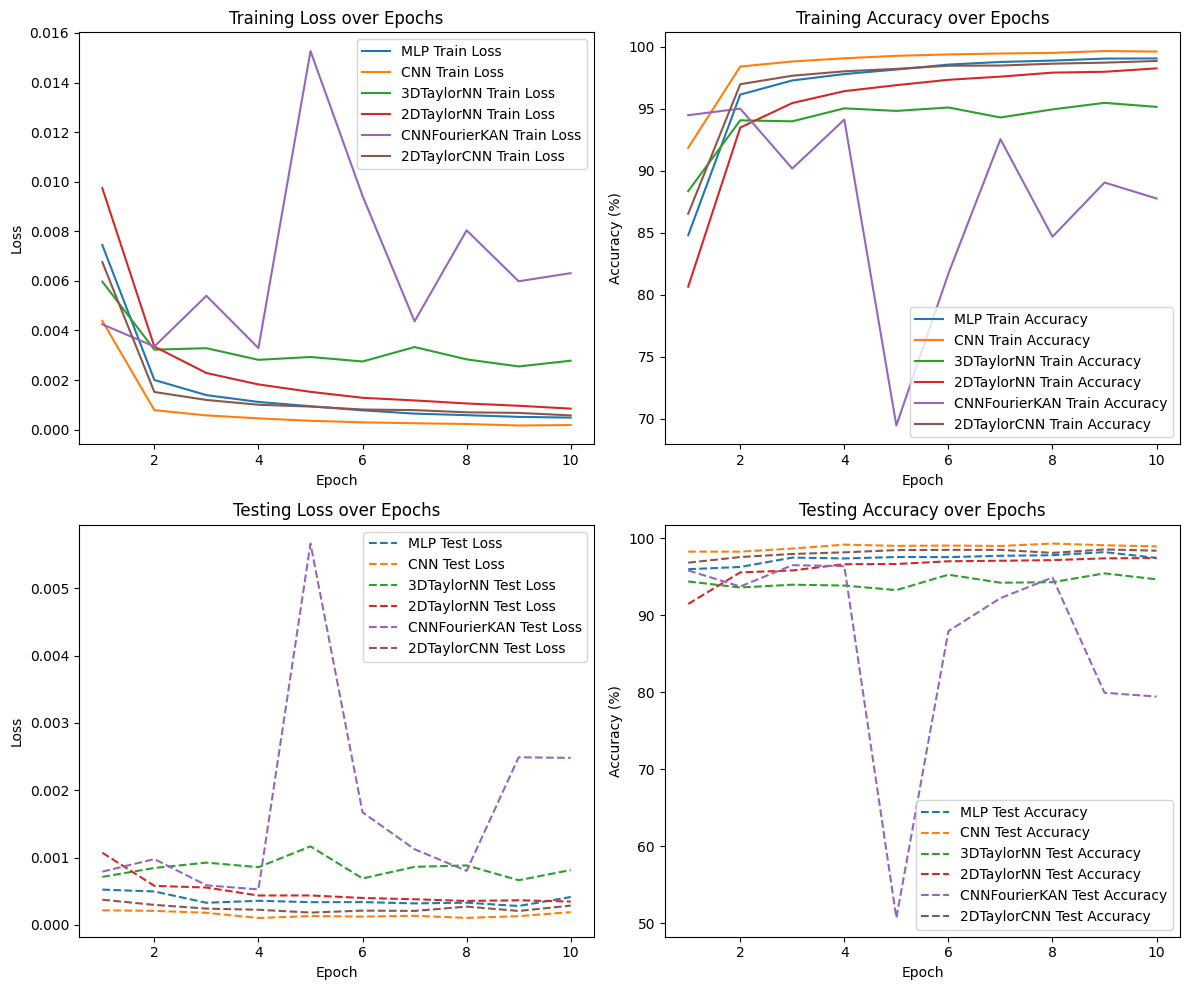

In [11]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

# TaylorKANLayer
class TaylorLayer(nn.Module):
    def __init__(self, input_dim, out_dim, order, addbias=True):
        super(TaylorLayer, self).__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim
        self.order = order
        self.addbias = addbias

        self.coeffs = nn.Parameter(torch.randn(out_dim, input_dim, order) * 0.01)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, out_dim))

    def forward(self, x):
        shape = x.shape
        outshape = shape[0:-1] + (self.out_dim,)
        x = torch.reshape(x, (-1, self.input_dim))

        x_expanded = x.unsqueeze(1).expand(-1, self.out_dim, -1)

        y = torch.zeros((x.shape[0], self.out_dim), device=x.device)

        for i in range(self.order):
            term = (x_expanded ** i) * self.coeffs[:, :, i]
            y += term.sum(dim=-1)

        if self.addbias:
            y += self.bias

        y = torch.reshape(y, outshape)
        return y

# FourierKANLayer
class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim
        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32))
        self.fouriercoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        nn.init.xavier_uniform_(self.fouriercoeffs)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))

    def forward(self, x):
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        outshape = x.shape[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))

        if self.addbias:
            y += self.bias

        y = torch.reshape(y, outshape)
        return y

# Different Models 
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class TaylorNN(nn.Module):
    def __init__(self, order):
        super(TaylorNN, self).__init__()
        self.order = order
        self.taylor1 = TaylorLayer(28*28, 128, order)
        self.taylor2 = TaylorLayer(128, 64, order)
        self.taylor3 = TaylorLayer(64, 10, order)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.selu(self.taylor1(x))
        x = F.selu(self.taylor2(x))
        x = self.taylor3(x)
        return x

class CNNFourierKAN(nn.Module):
    def __init__(self):
        super(CNNFourierKAN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.fourierkan1 = NaiveFourierKANLayer(32*7*7, 128, initial_gridsize=3)
        self.fourierkan2 = NaiveFourierKANLayer(128, 10, initial_gridsize=3)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fourierkan1(x)
        x = self.fourierkan2(x)
        return x

class TaylorCNN(nn.Module):
    def __init__(self):
        super(TaylorCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.taylorkan1 = TaylorLayer(32*7*7, 64, 2)
        self.taylorkan2 = TaylorLayer(64, 10, 2)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.taylorkan1(x)
        x = self.taylorkan2(x)
        return x

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, device, train_loader, optimizer):
    model.train()
    correct = 0
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    return average_loss, accuracy

def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

def run(num_epochs, model, device, train_loader, test_loader, optimizer):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    start_time = time.time()
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer)
        test_loss, test_accuracy = evaluate(model, device, test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    total_time = time.time() - start_time
    return train_losses, test_losses, train_accuracies, test_accuracies, total_time

# Computing Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_epochs = 10

models = {
    'MLP': MLP().to(device),
    'CNN': CNN().to(device),
    '3DTaylorNN': TaylorNN(3).to(device),
    '2DTaylorNN': TaylorNN(2).to(device),
    'CNNFourierKAN': CNNFourierKAN().to(device),
    '2DTaylorCNN': TaylorCNN().to(device)
}

optimizers = {
    'MLP': optim.RAdam(models['MLP'].parameters(), lr=0.001),
    'CNN': optim.RAdam(models['CNN'].parameters(), lr=0.001),
    '3DTaylorNN': optim.RAdam(models['3DTaylorNN'].parameters(), lr=0.001),
    '2DTaylorNN': optim.RAdam(models['2DTaylorNN'].parameters(), lr=0.001),
    'CNNFourierKAN': optim.RAdam(models['CNNFourierKAN'].parameters(), lr=0.001),
    '2DTaylorCNN': optim.RAdam(models['2DTaylorCNN'].parameters(), lr=0.001)
}

# Running
results = {}
for model_name in models:
    print(f"Training {model_name}")
    model = models[model_name]
    optimizer = optimizers[model_name]
    train_losses, test_losses, train_accuracies, test_accuracies, total_time = run(num_epochs, model, device, train_loader, test_loader, optimizer)
    total_params = count_parameters(model)
    final_test_accuracy = test_accuracies[-1]
    results[model_name] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'total_time': total_time,
        'total_params': total_params
    }
    print(f"{model_name} - Training time: {total_time:.2f} seconds; Total trainable parameters: {total_params}; Final test accuracy: {final_test_accuracy:.2f}%")

plt.figure(figsize=(12, 10))

# Plot training result
plt.subplot(2, 2, 1)
for model_name in results:
    plt.plot(range(1, num_epochs + 1), results[model_name]['train_losses'], label=f'{model_name} Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(2, 2, 2)
for model_name in results:
    plt.plot(range(1, num_epochs + 1), results[model_name]['train_accuracies'], label=f'{model_name} Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs')
plt.legend()

# Plot testing result
plt.subplot(2, 2, 3)
for model_name in results:
    plt.plot(range(1, num_epochs + 1), results[model_name]['test_losses'], label=f'{model_name} Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss over Epochs')
plt.legend()

plt.subplot(2, 2, 4)
for model_name in results:
    plt.plot(range(1, num_epochs + 1), results[model_name]['test_accuracies'], label=f'{model_name} Test Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()